In [1]:
import sys
import os
sys.path.append('..')
import torchvision.transforms as T
import matplotlib.pyplot as plt

from wildlife_tools.data import WildlifeDataset
# from wildlife_tools.inference import KnnClassifier

import pandas as pd
import itertools
from torch.optim import SGD
from utils.trainer_pl import basic_trainer_pl
from models.template_model import TemplateModel
from utils.triplet_loss_utils import TripletLoss_wildlife

from utils.triplet_loss_utils import KnnClassifier
from wildlife_tools.similarity import CosineSimilarity
from sklearn.metrics import precision_score, recall_score, f1_score

import timm
import torch.nn as nn
from pytorch_lightning import LightningModule
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_lightning import Trainer
import numpy as np
from PIL import Image
import wandb
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from wildlife_datasets import analysis, datasets, loader
from wildlife_tools.features import DeepFeatures
from utils.visualization import query_prediction_results_similarity, query_prediction_results_similarity_preprocessed
from data.wildlife_dataset import WildlifeDataModule
from data.raptors_wildlife import Raptors, GoldensWildlife
from models.resnet_plus_model import ResNetPlusModel





/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
# Reproduce just ONE animal :: Raptors
# create a config dict
config = {}
config['wildlife_name'] = 'raptors'
config['animal_cat'] = 'bird'
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/raptor_individuals_cropped'
config['cache_path']= '/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_raptors.csv' # CACHE
config['preprocess_lvl'] = 3 # PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] =224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'custom_closed' # custom_closed / metadata_split
config['only_cache'] = True # True / False
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0
config['custom_transform'] = False
config['use_gradcam'] = False
config['precompute'] = True


dataset1 = Raptors(root=config['dataset'])
dataset1.df['wildlife_name'] = 'raptors'
dataset1.df['identity'] = dataset1.df['identity'].apply(lambda x: 'raptors-' + str(x))

dataset_df = dataset1.df

data = WildlifeDataModule(metadata=dataset_df, config = config)

Dataset size before pre-processing and cleaning: 509
Removed 0 rows with invalid segmentation data.
Split: closed-set
Samples: train/test/unassigned/total = 382/127/0/509
Classes: train/test/unassigned/total = 69/53/0/69
Classes: train only/test only/joint  = 16/0/53

Fraction of train set     = 75.05%
Fraction of test set only = 0.00%
Training Set
Length: 382
Number of individuals (classes): 69
Mean images/individual: 5.536231884057971
Min images/individual: 2
Max images/individual: 48
Test Set
Length: 127
Number of individuals (classes): 53
Mean images per individual: 2.3962264150943398
Min images per individual: 1
Max images per individual: 8
Starting precomputation for bbox_mask (382 images)...
Processing image 1/382
Parsed bbox: [14.137499809265137, 13.087499618530273, 351.6703004837036, 97.91250038146973] -> [14, 13, 352, 98]
 mask shape before bbox crop: (111, 377)
 mask shape after bbox crop: (98, 352)
Processing image 2/382
Parsed bbox: [387.6000061035156, 265.1999816894531, 1

In [5]:
data.train_dataset.metadata.head()

image_id species  identity_id         identity  \
0       273  goleag         33.0  Alabama_natchez   
1       274  goleag         33.0  Alabama_natchez   
2       282  goleag         36.0  Bernheim_athena   
3       283  goleag         36.0  Bernheim_athena   
4       287  goleag         36.0  Bernheim_athena   

                                                path  from_video  video  date  \
0           goleag/Alabama_natchez/mfdc6688_crop.jpg       False    NaN  2000   
1                 goleag/Alabama_natchez/Natchez.jpg       False    NaN  2000   
2  goleag/Bernheim_athena/Athena_June2023-scaled.png       False    NaN  2023   
3          goleag/Bernheim_athena/Athenajan_2023.png       False    NaN  2023   
4       goleag/Bernheim_athena/Athena-Nov-2022-2.jpg       False    NaN  2022   

                                        segmentation  height   width  \
0  [[101.9078140258789, 13.087499618530273, 101.3...   111.0   377.0   
1  [[1027.6500244140625, 265.1999816894531, 1025....  1224.0  1632.0   
2  [[256.1062316894531, 20.749998092651367, 253.1...   277.0   628.0   
3  [[730.25, 166.60000610351562, 727.075012207031...  1146.0  2032.0   
4  [[700.546875, 200.8874969482422, 698.545288085...   690.0  1281.0   

                                                bbox       area  iscrowd  \
0  [14.137499809265137, 13.087499618530273, 351.6...    14152.0      0.0   
1  [387.6000061035156, 265.1999816894531, 1241.84...  1008001.0      0.0   
2  [39.25, 20.749998092651367, 560.2937622070312,...    64045.0      0.0   
3  [177.8000030517578, 166.60000610351562, 1539.8...  1101711.0      0.0   
4  [384.29998779296875, 200.8874969482422, 478.37...   144038.0      0.0   

                                           keypoints  num_keypoints  \
0  [190, 41, 2, 197, 44, 2, 186, 41, 2, 193, 55, ...           23.0   
1  [1029, 288, 2, 873, 528, 2, 861, 528, 2, 430, ...           23.0   
2  [97, 51, 2, 86, 78, 2, 86, 83, 2, 48, 83, 2, 8...           23.0   
3  [773, 186, 2, 1044, 487, 2, 1059, 502, 2, 1645...           23.0   
4  [748, 208, 2, 771, 236, 2, 771, 236, 2, 852, 2...           23.0   

   orientation  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

def visualize_precomputed_sample(dataset, index, npz_path, show_original=True):
    """
    Visualize a sample from the PrecomputedWildlife dataset with its precomputed components
    
    Args:
        dataset: Wildlife dataset instance
        index: Index of sample to visualize
        npz_path: Path to precomputed .npz file
        show_original: Whether to show original uncropped image
    """
    # Load metadata and precomputed data
    data = dataset.metadata.iloc[index]
    npz_data = np.load(npz_path, allow_pickle=True)
    filename = os.path.splitext(os.path.basename(data['path']))[0]
    
    # Load image
    img_path = os.path.join(dataset.root, data['path'])
    original_img = Image.open(img_path)
    
    # Get bbox and crop
    bbox = eval(data['bbox']) if isinstance(data['bbox'], str) else data['bbox']
    bbox = [int(x) for x in bbox]  # Ensure integer coordinates
    cropped_img = original_img.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
    
    # Get precomputed data
    components = {
        'mask': npz_data['masks'].item().get(filename),
        'components': npz_data['components'].item().get(filename) if 'components' in npz_data else None
    }
    
    # Determine what to plot
    to_plot = []
    if show_original:
        to_plot.append(('Original Image', original_img))
    to_plot.append(('Cropped Image', cropped_img))
    
    if components['mask'] is not None:
        to_plot.append(('Mask', components['mask']))
    
    if components['components'] is not None:
        if isinstance(components['components'], dict):
            for name, comp in components['components'].items():
                if isinstance(comp, np.ndarray):
                    to_plot.append((f'Component: {name}', comp))
        elif isinstance(components['components'], (list, np.ndarray)):
            for i, comp in enumerate(components['components']):
                to_plot.append((f'Component {i+1}', comp))
    
    # Create figure
    num_plots = len(to_plot)
    fig, axes = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))
    if num_plots == 1:
        axes = [axes]
    
    # Plot each element
    for ax, (title, img_data) in zip(axes, to_plot):
        if isinstance(img_data, Image.Image):
            ax.imshow(img_data)
        elif isinstance(img_data, np.ndarray):
            if img_data.dtype == np.bool_ or img_data.dtype == bool:
                ax.imshow(img_data, cmap='gray')
            elif img_data.dtype == np.float32 or img_data.dtype == np.float64:
                # Normalize float images to [0,1] range
                img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())
                ax.imshow(img_data)
            else:
                ax.imshow(img_data.astype(np.uint8))
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [7]:
npz_path="/Users/amee/Documents/code/master-thesis/EagleID/dataset/data_cache/precomputed_skeletons.npz"
def inspect_npz_contents(npz_path):
    """Check what's actually stored in the NPZ file"""
    with np.load(npz_path, allow_pickle=True) as data:
        print("Keys in NPZ file:", list(data.keys()))
        
        if 'masks' in data:
            the_dict = data['masks'].item()
            print(f"\nlen of dict: {len(the_dict)}")

            print(the_dict.keys())
            print("Sample keys:", list(the_dict.keys())[:3])  # Show first 3 keys
            print("Sample value:", list(the_dict.values())[:1])  # Show first value

inspect_npz_contents(npz_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amee/Documents/code/master-thesis/EagleID/dataset/data_cache/precomputed_skeletons.npz'

In [ ]:
def visualize_precomputed_sample(dataset, index, npz_dir, show_original=True, figsize_per_image=5):
    """
    Enhanced visualization of precomputed samples with skeletons, heatmaps, and components
    
    Args:
        dataset: Wildlife dataset instance
        index: Index of sample to visualize
        npz_dir: Directory to precomputed .npz files
        show_original: Whether to show original uncropped image
        figsize_per_image: Base size for each subplot
    """
    # Load metadata and precomputed data
    data = dataset.metadata.iloc[index]
    filename = os.path.splitext(os.path.basename(data['path']))[0]

    precomputed = {}
    npz_mask_path = os.path.join(npz_dir, 'precomputed_masks' + '.npz')
    if os.path.exists(npz_mask_path):
        npz_mask_data = np.load(npz_mask_path, allow_pickle=True)
        precomputed['mask'] = npz_mask_data['masks'].item().get(filename)
    npz_skeleton_path = os.path.join(npz_dir, 'precomputed_skeletons' + '.npz')
    if os.path.exists(npz_skeleton_path):
        npz_skeleton_data = np.load(npz_skeleton_path, allow_pickle=True)
        precomputed['skeleton'] = npz_skeleton_data['skeleton'].item().get(filename)
    npz_heatmap_path = os.path.join(npz_dir, 'precomputed_heatmaps' + '.npz')
    if os.path.exists(npz_heatmap_path):
        npz_heatmap_data = np.load(npz_heatmap_path, allow_pickle=True)
        precomputed['heatmaps'] = npz_heatmap_data['heatmaps'].item().get(filename)
    npz_component_path = os.path.join(npz_dir, 'precomputed_components' + '.npz')
    if os.path.exists(npz_component_path):
        npz_component_data = np.load(npz_component_path, allow_pickle=True)
        precomputed['components'] = npz_component_data['components'].item().get(filename)

    
    
    # Load image and get label string
    img_path = os.path.join(dataset.root, data['path'])
    original_img = Image.open(img_path)
    label_str = data[dataset.col_label] if dataset.col_label in data else "N/A"
    
    # Get bbox and crop
    bbox = eval(data['bbox']) if isinstance(data['bbox'], str) else data['bbox']
    bbox = [int(x) for x in bbox]  # Ensure integer coordinates
    cropped_img = original_img.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
    
    # Determine what to plot
    to_plot = []
    if show_original:
        to_plot.append(('Original Image', original_img, None))
    to_plot.append((f'Cropped Image\nLabel: {label_str}', cropped_img, None))
    
    # Add mask if available
    if precomputed['mask'] is not None:
        to_plot.append(('Mask', precomputed['mask'], 'gray'))
    
    # Add skeleton if available
    if 'skeleton' in precomputed and precomputed['skeleton'] is not None:
        to_plot.append(('Skeleton', precomputed['skeleton'], 'viridis'))
    
    # Add heatmaps if available
    if 'heatmaps' in precomputed and precomputed['heatmaps'] is not None:
        for i, heatmap in enumerate(precomputed['heatmaps']):
            to_plot.append((f'Heatmap {i+1}', heatmap, 'hot'))
    
    # Add components if available
    if 'components' in precomputed and precomputed['components'] is not None:
        if isinstance(precomputed['components'], dict):
            for name, comp in precomputed['components'].items():
                if comp is not None:
                    to_plot.append((f'Component: {name}', comp, None))
        elif isinstance(precomputed['components'], (list, np.ndarray)):
            for i, comp in enumerate(precomputed['components']):
                if comp is not None:
                    to_plot.append((f'Component {i+1}', comp, None))
    
    # Create figure
    num_plots = len(to_plot)
    fig, axes = plt.subplots(1, num_plots, figsize=(figsize_per_image*num_plots, figsize_per_image))
    if num_plots == 1:
        axes = [axes]
    
    # Plot each element
    for ax, (title, img_data, cmap) in zip(axes, to_plot):
        if isinstance(img_data, Image.Image):
            ax.imshow(img_data)
        elif isinstance(img_data, np.ndarray):
            if img_data.dtype == np.bool_ or img_data.dtype == bool:
                ax.imshow(img_data, cmap='gray')
            elif img_data.dtype == np.float32 or img_data.dtype == np.float64:
                # Normalize float images to [0,1] range
                img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())
                ax.imshow(img_data, cmap=cmap)
            else:
                ax.imshow(img_data.astype(np.uint8), cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

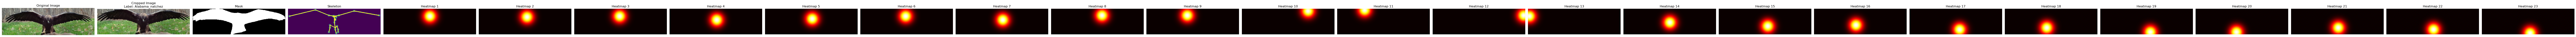

In [ ]:
visualize_precomputed_sample(
    dataset=data.train_dataset,
    index=0,  # Example index
    npz_dir="/Users/amee/Documents/code/master-thesis/EagleID/dataset/data_cache/",
    show_original=True
)


Batch Size: 4
Image Shape: torch.Size([4, 4, 224, 224])
Labels Shape: torch.Size([4])


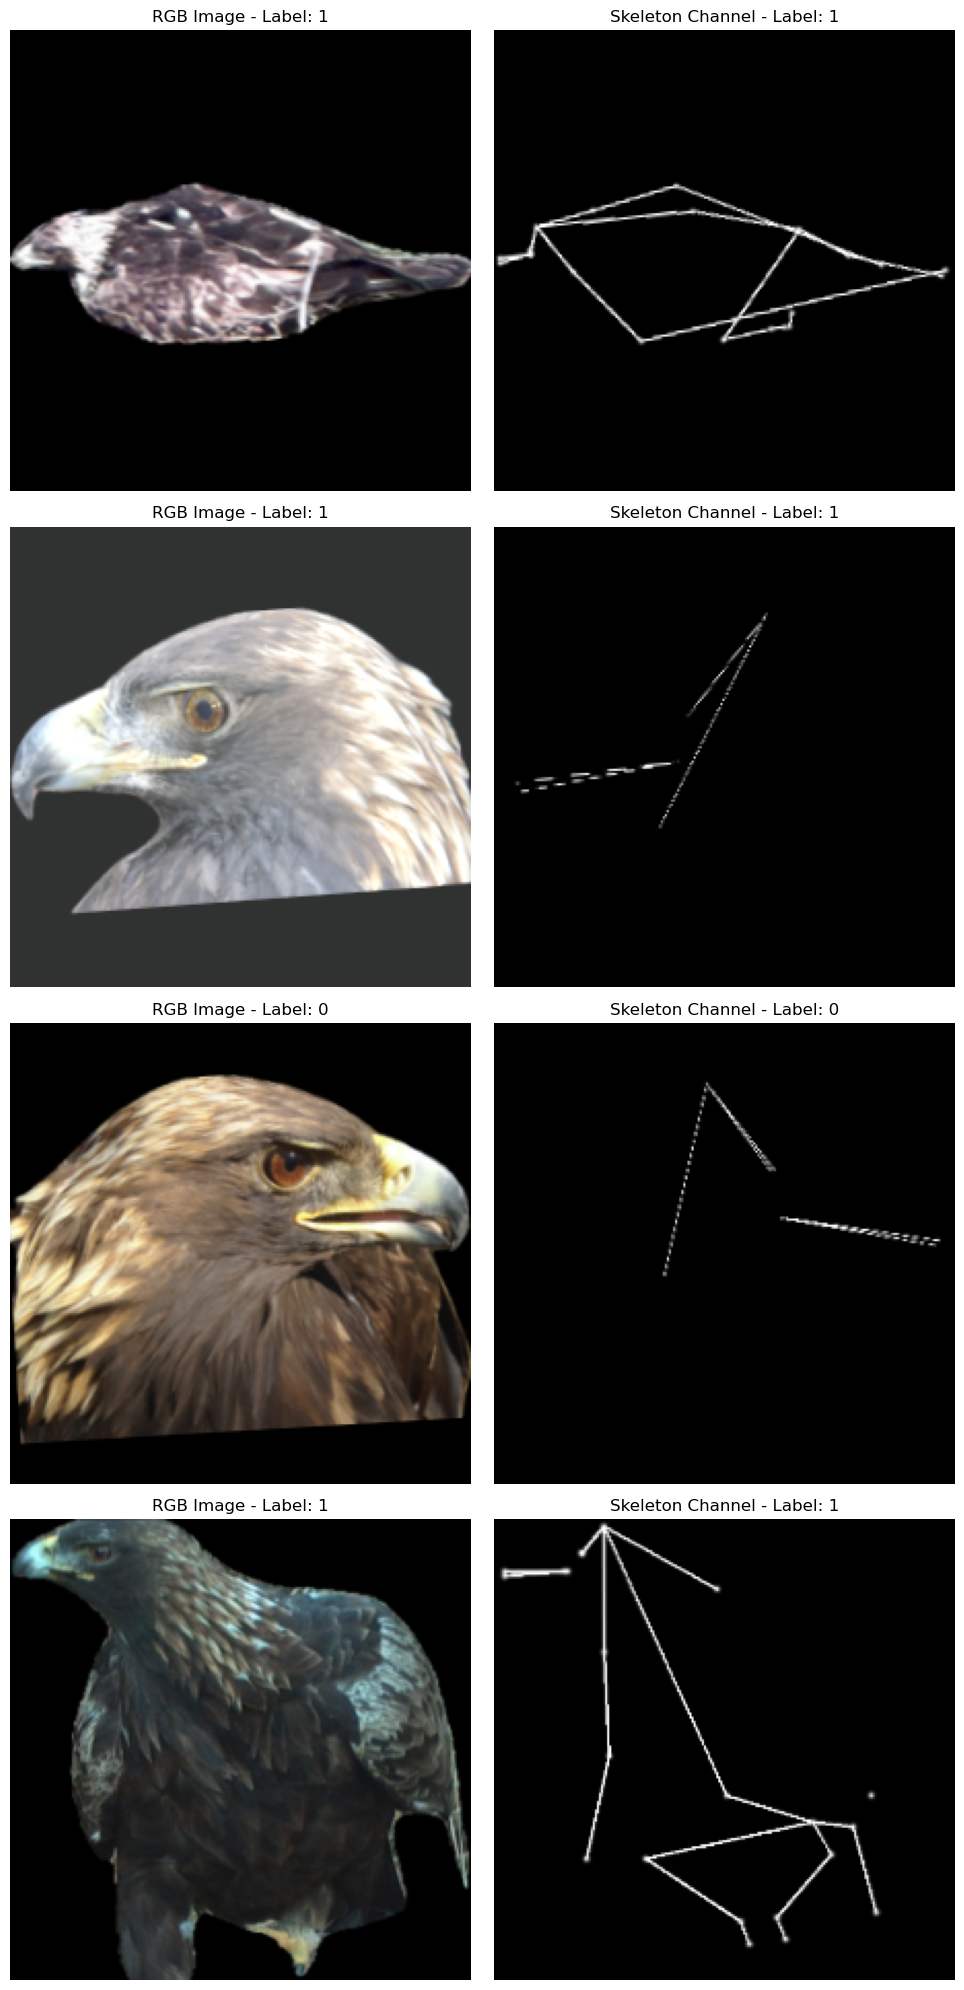

In [ ]:
# SKELETON
import matplotlib.pyplot as plt
import numpy as np
from data.transforms import denormalize


mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
train_dataloader = data.train_dataloader()

batch = next(iter(train_dataloader))
images, labels = batch

print("Batch Size:", images.size(0))
print("Image Shape:", images.shape)
print("Labels Shape:", labels.shape)

# Plot the images and their skeletons side by side
fig, axes = plt.subplots(4, 2, figsize=(10, 20))  # 4 rows, 2 columns (RGB and skeleton for each image)
axes = axes.flatten()

for i in range(4):  # Assuming batch size is at least 4

    image_np = images[i].numpy()  # Convert from PyTorch tensor to numpy array
    image_np = denormalize(image_np, mean, std)  # Denormalize the First 3 channels (RGB)

    skeleton_image = images[i][3].cpu().numpy()  # 4th channel (Skeleton)

    image_np = np.transpose(image_np, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plotting
    label = labels[i].item()  # Convert label tensor to Python scalar using .item()

    # Plot RGB image
    ax_rgb = axes[i * 2]
    ax_rgb.imshow(image_np)
    # ax_rgb.imshow(np.clip(image_np, 0, 1))  # Clip values to [0, 1] for valid image display
    ax_rgb.set_title(f'RGB Image - Label: {labels[i].item()}')
    ax_rgb.axis('off')

    # Plot Skeleton image (grayscale)
    ax_skel = axes[i * 2 + 1]
    ax_skel.imshow(skeleton_image, cmap='gray')  # Plot skeleton channel as a grayscale image
    ax_skel.set_title(f'Skeleton Channel - Label: {labels[i].item()}')
    ax_skel.axis('off')

plt.tight_layout()
plt.show()

Batch Size: 4
Image Shape: torch.Size([4, 26, 224, 224])
Labels Shape: torch.Size([4])


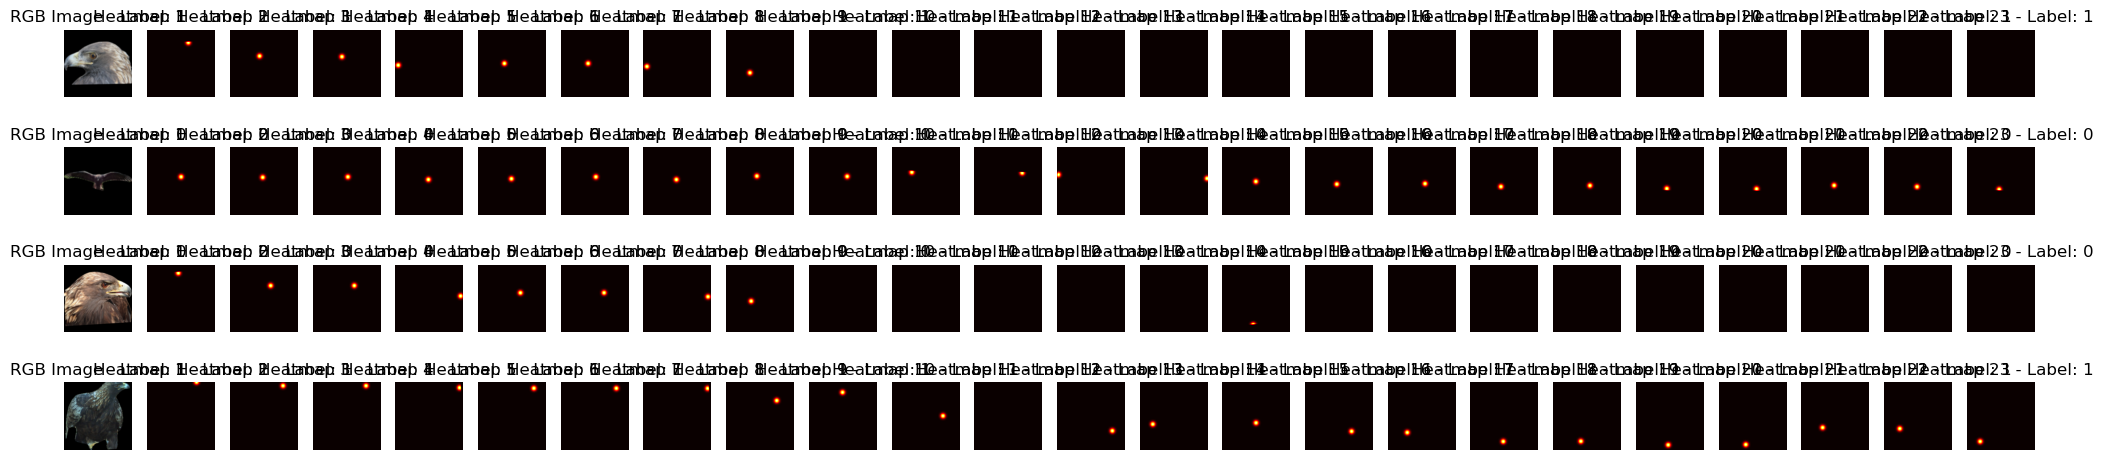

In [ ]:
#HEATMAPS
import matplotlib.pyplot as plt
import numpy as np
from data.transforms import denormalize


mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
train_dataloader = data.train_dataloader()

batch = next(iter(train_dataloader))
images, labels = batch

print("Batch Size:", images.size(0))
print("Image Shape:", images.shape)  # Should be [Batch, 3 + num_heatmaps, H, W]
print("Labels Shape:", labels.shape)

# Define the number of heatmaps (channels) after the RGB channels
num_heatmaps = images.shape[1] - 3  # Subtract RGB channels

# Plot the images and their heatmaps side by side
fig, axes = plt.subplots(4, num_heatmaps + 1, figsize=(20, 5))  # 4 rows, num_heatmaps + 1 columns
axes = axes.flatten()

for i in range(4):  # Assuming batch size is at least 4
    # Extract the RGB channels
    image_np = images[i][:3].numpy()  # Take first 3 channels (RGB)
    image_np = denormalize(image_np, mean, std)  # Denormalize the RGB channels
    image_np = np.transpose(image_np, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plotting
    label = labels[i].item()  # Convert label tensor to Python scalar using .item()

    # Plot RGB image
    ax_rgb = axes[i * (num_heatmaps + 1)]
    ax_rgb.imshow(image_np)  # Remove clipping here, as image_np should be in [0, 1] range now
    ax_rgb.set_title(f'RGB Image - Label: {labels[i].item()}')
    ax_rgb.axis('off')

    # Plot each heatmap (grayscale)
    for j in range(num_heatmaps):
        heatmap = images[i][3 + j].cpu().numpy()  # Get the heatmap (after the 3 RGB channels)
        
        # Normalize the heatmap if necessary (if values are too small/large)
        if heatmap.max() > 0:
            heatmap = heatmap / heatmap.max()  # Normalize to [0, 1]

        # Plot the heatmap
        ax_heatmap = axes[i * (num_heatmaps + 1) + (j + 1)]
        ax_heatmap.imshow(heatmap, cmap='hot')  # Plot heatmap as a grayscale image
        ax_heatmap.set_title(f'Heatmap {j + 1} - Label: {labels[i].item()}')
        ax_heatmap.axis('off')

plt.tight_layout()
plt.show()

Batch Size: 4
Image Shape: torch.Size([4, 18, 224, 224])
Labels Shape: torch.Size([4])


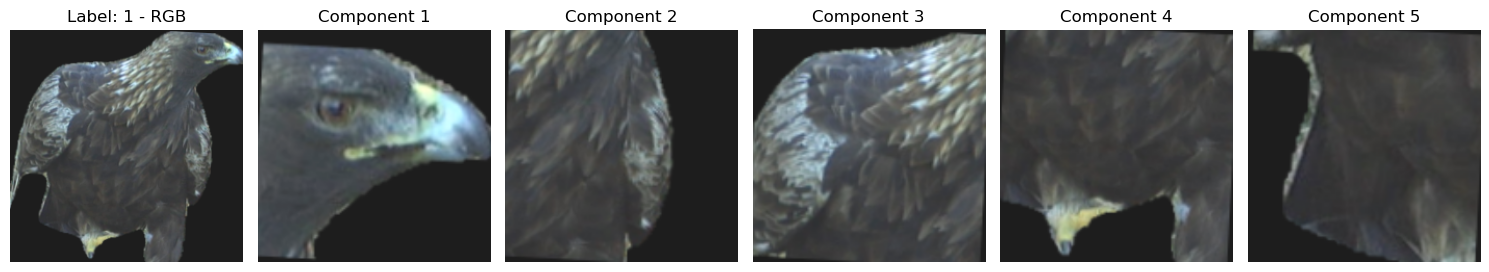

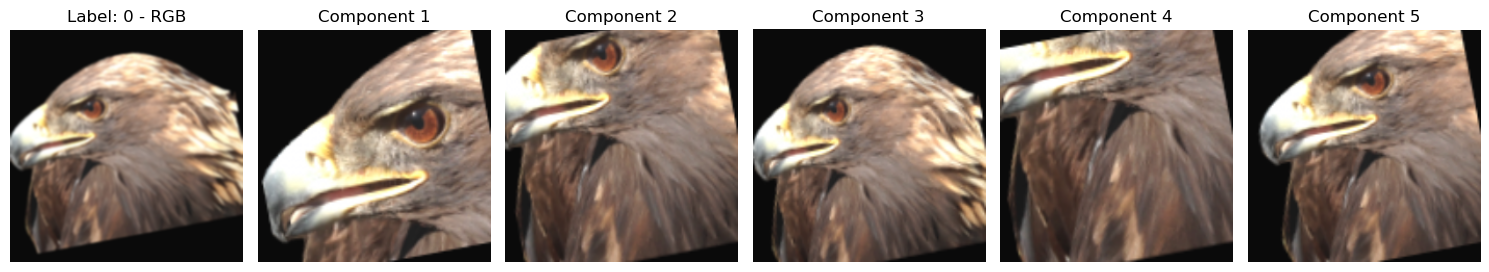

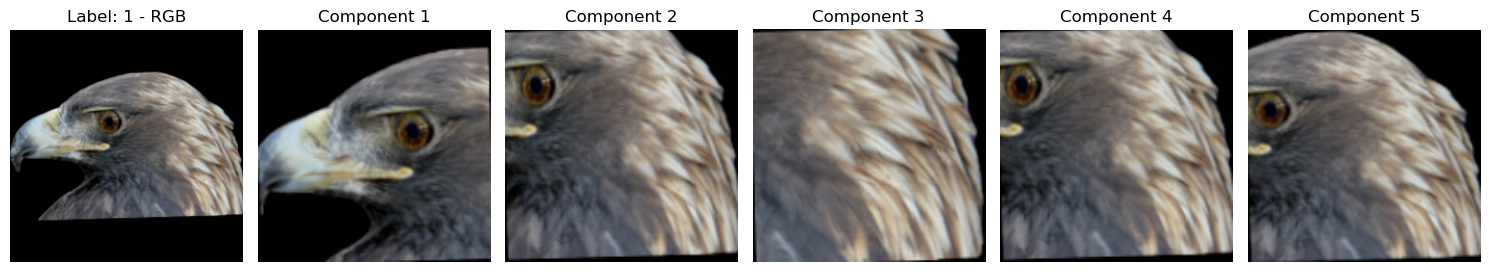

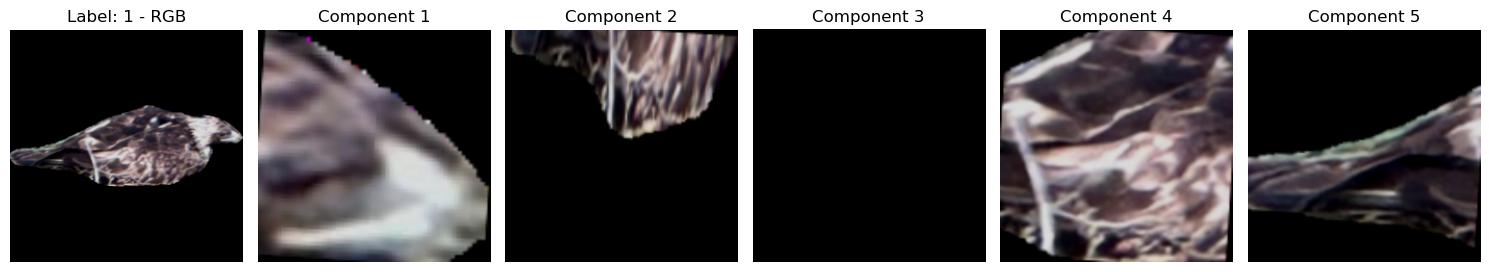

In [ ]:
# COMPONENTS
import numpy as np
from data.transforms import denorm_RGB_components

# Mean and standard deviation values to denormalize each RGB channel
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

train_dataloader = data.train_dataloader()

# Fetch a batch of images (assuming batch size is 8 for example)
batch = next(iter(train_dataloader))
images, labels = batch
print("Batch Size:", images.size(0))
print("Image Shape:", images.shape)  # Expected shape: (batch_size, channels, height, width)
print("Labels Shape:", labels.shape)

for i in range(images.size(0)):  # Loop through each image in the batch
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))  # Create 2x3 grid for each image
    axes = axes.flatten()

    # Extract the full image with RGB + component channels
    full_image = images[i].numpy()  # Shape: (channels, height, width)

    # Denormalize the full image (including RGB and component channels)
    full_image_denorm = denorm_RGB_components(full_image, mean, std)

    # Plot RGB image (first 3 channels)
    rgb_image = full_image_denorm[:3]  # Extract the first 3 channels (RGB)
    rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Convert to (H, W, C) for plotting
    
    ax = axes[0]
    ax.imshow(rgb_image.astype(np.uint8))  # Convert back to integer type for proper visualization
    ax.set_title(f'Label: {labels[i].item()} - RGB')
    ax.axis('off')

    # Plot component channels (next 5 sets of 3 channels each)
    for j in range(5):  # Assuming 5 components, each with 3 channels
        # Extract the next set of 3 channels for the current component
        component_channels = full_image_denorm[3 + (j * 3): 3 + (j * 3) + 3]  # Extract the component channels
        component_image = np.transpose(component_channels, (1, 2, 0))  # Convert to (H, W, C) for plotting

        ax = axes[j + 1]  # Move to the next subplot (j + 1 because axes[0] is used for RGB)
        ax.imshow(component_image.astype(np.uint8))  # Convert back to integer type for proper visualization
        ax.set_title(f'Component {j + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
config['backbone_name'] = 'resnet50'
config['embedding_size'] = 128
config['triplet_loss'] = {}
config['triplet_loss']['margin'] = 0.2
config['triplet_loss']['mining_type'] = "semihard"
config['triplet_loss']['distance_matrix'] = 'cosine'
config['re_ranking'] = True
config['solver'] = {}
config['solver']['BASE_LR'] = 0.001
config['solver']['OPT'] = 'adam'
config['solver']['WEIGHT_DECAY'] = 0.0001
config['solver']['LR_SCHEDULER'] = 'step'
config['solver']['LR_STEP_SIZE'] = 10
config['solver']['LR_DECAY_RATE'] = 0.1
config['outdir'] = "train_trial_results"
config['use_wandb'] = False


model = ResNetPlusModel(config = config)


trainer = Trainer(accelerator="cpu", max_epochs=1)
trainer.fit(model, data)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | backbone    | Feature

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Processing image 1/49
 img path filename: both_athena_newpartner
 img full size: (451, 300)
Parsed bbox: [2.8187501430511475, 9.0625, 437.61093735694885, 283.2843933105469] -> [3, 9, 438, 283]
 bbox used in getitem: [3, 9, 438, 283]
 img cropped size: (438, 283)
 mask shape in getitem: (283, 438)
 img masked size: (438, 283)
Processing image 2/49
 img path filename: july-2018
 img full size: (688, 960)
Parsed bbox: [253.99998474121094, 324.0, 113.99998474121094, 126.0] -> [254, 324, 114, 126]
 bbox used in getitem: [254, 324, 114, 126]
 img cropped size: (114, 126)
 mask shape in getitem: (126, 114)
 img masked size: (114, 126)
Processing image 3/49
 img path filename: inthesky
 img full size: (946, 666)
Parsed bbox: [325.1875, 108.32501220703125, 300.05938720703125, 214.328125] -> [325, 108, 300, 214]
 bbox used in getitem: [325, 108, 300, 214]
 img cropped size: (300, 214)
 mask shape in getitem: (214, 300)
 img masked size: (300, 214)
Processing image 4/49
 img path filename: nov-23

/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/metrics.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a).to(device=b.device if isinstance(b, torch.Tensor) else 'cpu')
/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/metrics.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(b).to(device=a.device)
/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T
/Users/amee/miniconda3

 img full size: (2239, 1422)
Parsed bbox: [181.91876220703125, 305.1812744140625, 1826.1843872070312, 570.2453002929688] -> [182, 305, 1826, 570]
 bbox used in getitem: [182, 305, 1826, 570]
 img cropped size: (1826, 570)
 mask shape in getitem: (570, 1826)
 img masked size: (1826, 570)
Processing image 15/78
 img path filename: 960x0
 img full size: (960, 1437)
Parsed bbox: [3.9937498569488525, 80.83124542236328, 956.0062501430511, 1353.9233932495117] -> [4, 81, 956, 1354]
 bbox used in getitem: [4, 81, 956, 1354]
 img cropped size: (956, 1354)
 mask shape in getitem: (1354, 956)
 img masked size: (956, 1354)
Processing image 16/78
 img path filename: kateri-7a
 img full size: (1200, 802)
Parsed bbox: [142.5, 55.999996185302734, 988.125, 738.749942779541] -> [142, 56, 988, 739]
 bbox used in getitem: [142, 56, 988, 739]
 img cropped size: (988, 739)
 mask shape in getitem: (739, 988)
 img masked size: (988, 739)


Training: |          | 0/? [00:00<?, ?it/s]

Processing image 235/382
 img path filename: 6th_081125-506H-289
 img full size: (450, 339)
Parsed bbox: [9.140625, 40.125, 416.25, 277.03125] -> [9, 40, 416, 277]
 bbox used in getitem: [9, 40, 416, 277]
 img cropped size: (416, 277)
 mask shape in getitem: (277, 416)
 img masked size: (416, 277)
Processing image 250/382
 img path filename: 428650760_18283237960090461_3457153218438158915_n
 img full size: (1440, 854)
Parsed bbox: [47.25, 85.0, 1390.5, 744.75] -> [47, 85, 1390, 745]
 bbox used in getitem: [47, 85, 1390, 745]
 img cropped size: (1390, 745)
 mask shape in getitem: (745, 1390)
 img masked size: (1390, 745)
Processing image 1/382
 img path filename: mfdc6688_crop
 img full size: (377, 111)
Parsed bbox: [14.137499809265137, 13.087499618530273, 351.6703004837036, 97.91250038146973] -> [14, 13, 352, 98]
 bbox used in getitem: [14, 13, 352, 98]
 img cropped size: (352, 98)
 mask shape in getitem: (98, 352)
 img masked size: (352, 98)
Processing image 21/382
 img path filename:

Validation: |          | 0/? [00:00<?, ?it/s]

Processing image 9/49
 img path filename: Aug2020-G274-Ainsley-Bennett
 img full size: (640, 427)
Parsed bbox: [172.0, 26.5, 191.0, 355.0] -> [172, 26, 191, 355]
 bbox used in getitem: [172, 26, 191, 355]
 img cropped size: (191, 355)
 mask shape in getitem: (355, 191)
 img masked size: (191, 355)
Processing image 10/49
 img path filename: Apr2022-G318 
 img full size: (1080, 1079)
Parsed bbox: [40.5, 215.5, 941.625, 656.4374389648438] -> [40, 216, 942, 656]
 bbox used in getitem: [40, 216, 942, 656]
 img cropped size: (942, 656)
 mask shape in getitem: (656, 942)
 img masked size: (942, 656)
Processing image 11/49
 img path filename: nov2020_G324-eating-fish
 img full size: (640, 466)
Parsed bbox: [164.0, 29.0, 299.0, 390.0] -> [164, 29, 299, 390]
 bbox used in getitem: [164, 29, 299, 390]
 img cropped size: (299, 390)
 mask shape in getitem: (390, 299)
 img masked size: (299, 390)
Processing image 12/49
 img path filename: Apr8-2020-G393-NorthYorkMoors-Egton-Emma-Thurlow
 img full si

/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/metrics.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a).to(device=b.device if isinstance(b, torch.Tensor) else 'cpu')
/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/metrics.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(b).to(device=a.device)
/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T
`Trainer.fit` stopped:

In [ ]:
checkpoint_path = '/Users/amee/Documents/code/master-thesis/EagleID/notebooks/lightning_logs/version_66/checkpoints/epoch=0-step=96.ckpt'
model = ResNetPlusModel.load_from_checkpoint(checkpoint_path)
# dataset_database_P = WildlifeDataset(metadata.df.iloc[100:,:], metadata.root, transform=transform)
# dataset_query_P = WildlifeDataset(metadata.df.iloc[:100,:], metadata.root, transform=transform)
dataset_query_P = data.val_query_dataset
dataset_database_P = data.val_gallery_dataset

# name = 'hf-hub:BVRA/MegaDescriptor-T-224'
extractor_P = DeepFeatures(model , device = 'cpu')

query_P, database_P = extractor_P(dataset_query_P), extractor_P(dataset_database_P)

similarity_function = CosineSimilarity()
similarity_P = similarity_function(query_P, database_P)
print(similarity_P)
classifier_P = KnnClassifier(k=1, database_labels=dataset_database_P.labels_string)
predictions_P = classifier_P(similarity_P['cosine'])
print("Predictions for 100 test Images:-\n",predictions_P)
accuracy_P = np.mean(dataset_query_P.labels_string == predictions_P)
print("Accuracy: {:.2f}%".format(accuracy_P * 100))

precision_P = precision_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
recall_P = recall_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
f1_P = f1_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
print("Precision:", precision_P)
print("Recall:", recall_P)
print("F1 Score:", f1_P)

/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/Users/amee/miniconda3/envs/pyto

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[49, 4, 224, 224] to have 3 channels, but got 4 channels instead

TypeError: '>' not supported between instances of 'str' and 'int'

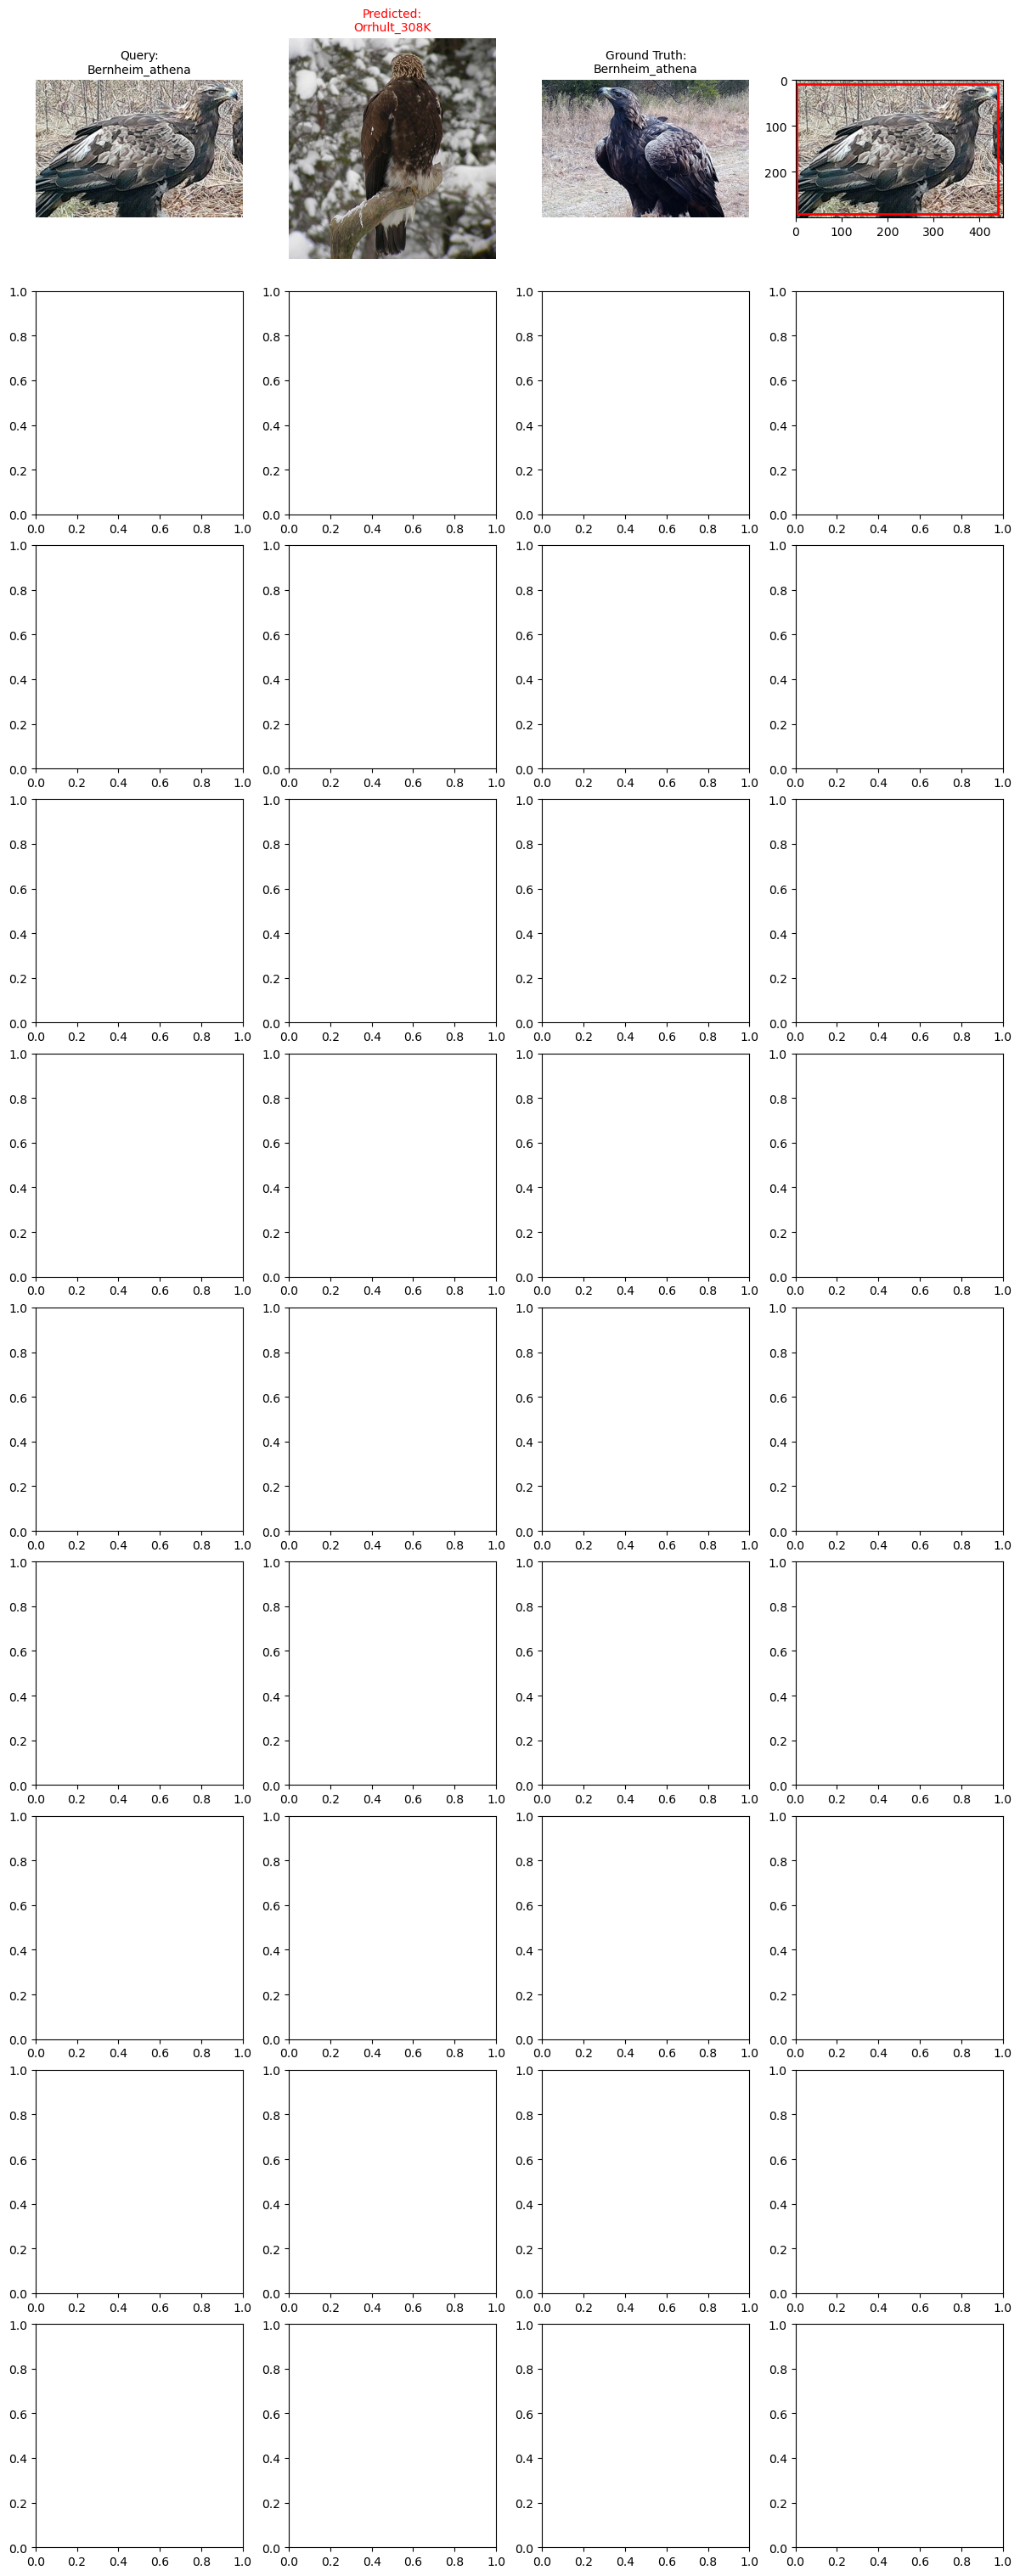

In [ ]:
query_prediction_results_similarity_preprocessed(
    root=config['dataset'],
    query_metadata=dataset_query_P.metadata,
    db_metadata=dataset_database_P.metadata,
    query_start=0,
    similarity_scores=similarity_P['cosine'],
    num_images=10,
    preprocess_option=3
    # preprocess_option=config['preprocess_lvl'],
)